<img src='./img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='20%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./30_cams_eac4_retrieve.ipynb"><< 30 - CAMS EAC4 - Retrieve</a><span style="float:right;">

<div class="alert alert-block alert-warning">
<b>LOAD, BROWSE AND VISUALIZE</b></div>

# Copernicus Atmosphere Monitoring Service (CAMS) Global Reanalysis (EAC4) 

The Copernicus Atmopshere Monitoring Service (CAMS) provides consistent and quality-controlled information related to air pollution and health and greenhouse gases. CAMS data consist of `global forecasts and analyses`, `global reanalyses (EAC4)`, `fire emissions` and `greenhouse gas flux inversions`.

This notebooks provides an introduction to the CAMS global reanalysis (EAC4) data. EAC4 (ECMWF Atmospheric Composition Reanalysis 4) is the 4th generation ECMWF global reanalysis of atmospheric composition. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset. As a trace gas for smoke and fires the variable `Organic Matter Aerosol Optical Depth` is used. Alternatively, you can use `Total Aerosol Optical Depth` or `Total Column Carbon Monoxide` to monitor fires.

CAMS EAC4 data are available in either `GRIB` or `netCDF` format. Get more information in the [CAMS Reanalysis data documentation](https://confluence.ecmwf.int/display/CKB/CAMS%3A+Reanalysis+data+documentation) and at the [Copernicus Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=overview).

#### Module outline:
* [1 - Load and browse organic matter aerosol optical depth (AOD) at 550nm](#load_browse)
* [2 - Bring longitude coordinates onto a (-180,180) grid](#shift)
* [3 - Retrieve the data variable organic matter AOD at 550nm as xarray DataArray](#data_retrieve)
* [4 - Visualize organic matter aerosol optical depth at 550nm](#visualize)

<hr>

#### Load required libraries

In [18]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh


#### Load helper functions

In [19]:
from ipynb.fs.full.functions import generate_geographical_subset

<hr>

### <a id='load_browse'></a>1. Load and browse `EAC4 reanalysis` data

CAMS global reanalysis data is available either in `GRIB` or `netCDF`. The data for this example is available in `netCDF`. You can use xarray's function `xr.open_dataset()` to open the netCDF file as xarray Dataset.

In [20]:
file = xr.open_dataset('../eodata/cams_eac4/20191225-31_cams_eac4.nc')
file


<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 56)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2019-12-25 ... 2019-12-31T21:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
    aod550     (time, latitude, longitude) float32 ...
    tcco       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-25 08:11:01 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

The data above has three dimensions (`latitude`, `longitude` and `time`) and three data variables:
* `omaod550`: Organic matter Aerosol Optical Depth at 550nm , 
* `aod550`: Total Aerosol Optical Depth at 550nm, and 
* `tcco`: Total Column Carbon Monoxide.

Let us inspect the coordinates of the file more in detail.

Below, you see that the data set consists of 56 time steps, ranging from 25 December 2019 00 UTC to 31 December 21 UTC in a three-hourly timestep.

In [21]:
file.time

<xarray.DataArray 'time' (time: 56)>
array(['2019-12-25T00:00:00.000000000', '2019-12-25T03:00:00.000000000',
       '2019-12-25T06:00:00.000000000', '2019-12-25T09:00:00.000000000',
       '2019-12-25T12:00:00.000000000', '2019-12-25T15:00:00.000000000',
       '2019-12-25T18:00:00.000000000', '2019-12-25T21:00:00.000000000',
       '2019-12-26T00:00:00.000000000', '2019-12-26T03:00:00.000000000',
       '2019-12-26T06:00:00.000000000', '2019-12-26T09:00:00.000000000',
       '2019-12-26T12:00:00.000000000', '2019-12-26T15:00:00.000000000',
       '2019-12-26T18:00:00.000000000', '2019-12-26T21:00:00.000000000',
       '2019-12-27T00:00:00.000000000', '2019-12-27T03:00:00.000000000',
       '2019-12-27T06:00:00.000000000', '2019-12-27T09:00:00.000000000',
       '2019-12-27T12:00:00.000000000', '2019-12-27T15:00:00.000000000',
       '2019-12-27T18:00:00.000000000', '2019-12-27T21:00:00.000000000',
       '2019-12-28T00:00:00.000000000', '2019-12-28T03:00:00.000000000',
       '2019-1

The latitude values have a 0.25 degrees resolution and have a global N-S coverage.

In [22]:
file.latitude

<xarray.DataArray 'latitude' (latitude: 241)>
array([ 90.  ,  89.25,  88.5 , ..., -88.5 , -89.25, -90.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Attributes:
    units:      degrees_north
    long_name:  latitude

The longitude values have a 0.25 degrees resolution as well, but are on a [0,360] grid instead of a [-180,180] grid. 

In [23]:
file.longitude

<xarray.DataArray 'longitude' (longitude: 480)>
array([  0.  ,   0.75,   1.5 , ..., 357.75, 358.5 , 359.25], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
Attributes:
    units:      degrees_east
    long_name:  longitude

### <a id='shift'></a>2. Bring longitude coordinates onto a [-180,180] grid

You can assign new values to coordinates in an xarray Dataset. You can do so with the `assign_coords()` function, which you can apply onto an xarray Dataset. With the code below, you shift your longitude grid from [0,360] to [-180,180]. At the end, you sort the longitude values in an ascending order.

In [24]:
file_assigned = file.assign_coords(longitude=(((file.longitude + 180) % 360) - 180)).sortby('longitude')
file_assigned

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 56)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2019-12-25 ... 2019-12-31T21:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 0.0010485649 ... 0.012378216
    aod550     (time, latitude, longitude) float32 0.006456852 ... 0.030357838
    tcco       (time, latitude, longitude) float32 0.0008804556 ... 0.00024561584
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-25 08:11:01 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

A quick check of the longitude coordinates of the new xarray Dataset shows you that the longitude values range now between [-180, 180].

In [25]:
file_assigned.longitude

<xarray.DataArray 'longitude' (longitude: 480)>
array([-180.  , -179.25, -178.5 , ...,  177.75,  178.5 ,  179.25],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25

### <a id='data_retrieve'></a>3. Retrieve the data variable `organic matter AOD at 550nm` as xarray DataArray

Let us store the data variable `organic matter AOD at 550nm` as xarray DataArray with the name `om_aod`.

In [26]:
om_aod = file_assigned.omaod550
om_aod

<xarray.DataArray 'omaod550' (time: 56, latitude: 241, longitude: 480)>
array([[[0.001049, 0.001049, ..., 0.001049, 0.001049],
        [0.001325, 0.001325, ..., 0.001325, 0.001325],
        ...,
        [0.005608, 0.005608, ..., 0.005608, 0.005608],
        [0.011135, 0.011135, ..., 0.011135, 0.011135]],

       [[0.001187, 0.001187, ..., 0.001187, 0.001187],
        [0.001049, 0.001049, ..., 0.001049, 0.001049],
        ...,
        [0.00699 , 0.00699 , ..., 0.00699 , 0.00699 ],
        [0.011273, 0.011273, ..., 0.011273, 0.011273]],

       ...,

       [[0.002569, 0.002569, ..., 0.002569, 0.002569],
        [0.002569, 0.00243 , ..., 0.002569, 0.002569],
        ...,
        [0.007957, 0.007957, ..., 0.007957, 0.007957],
        [0.015141, 0.015141, ..., 0.015141, 0.015141]],

       [[0.002569, 0.002569, ..., 0.002569, 0.002569],
        [0.002154, 0.002154, ..., 0.002154, 0.002154],
        ...,
        [0.006575, 0.006575, ..., 0.006575, 0.006575],
        [0.012378, 0.012378, ...

Above, you see that the variable `om_aod` has two attributes, `units` and `long_name`. Let us define variables for those attributes. The variables can be used for visualizing the data.

In [27]:
long_name = om_aod.long_name
units = om_aod.units

Let us do the same for the coordinates `longitude` and `latitude`.

In [28]:
latitude = om_aod.latitude
longitude = om_aod.longitude

### <a id='visualize'></a>4. Visualize `organic matter aerosol optical depth at 550nm`

Let us visualize the dataset. You can make use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.


You can make use of the variables we have defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the color scale and minimum and maxium data values.

Text(0.5, 1.0, 'Organic Matter Aerosol Optical Depth at 550nm')

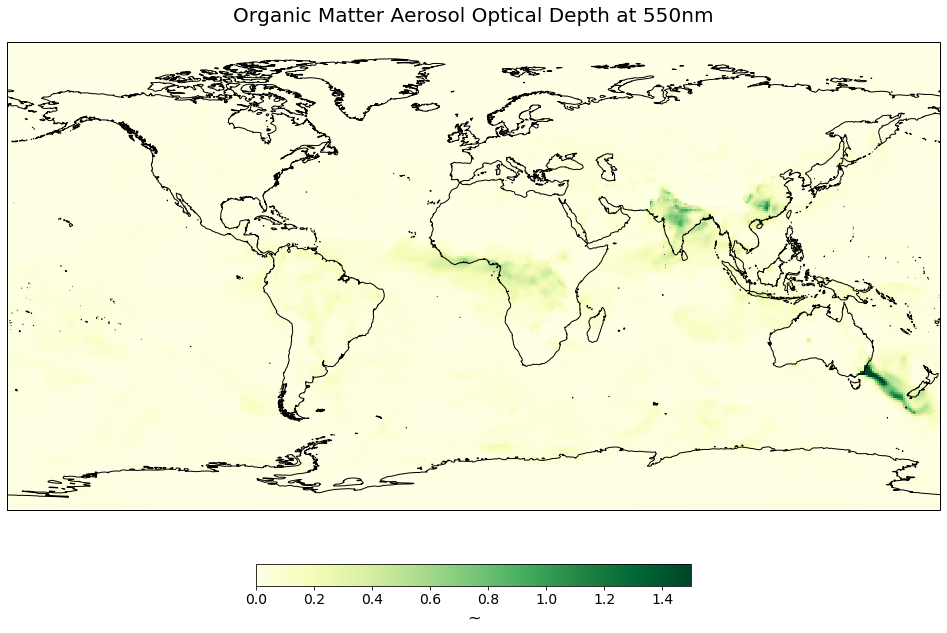

In [29]:
fig=plt.figure(figsize=(20, 10))

ax = plt.axes(projection=ccrs.PlateCarree())
img = plt.pcolormesh(longitude, latitude, om_aod[50,:,:], 
                    cmap=plt.get_cmap('YlGn'), transform=ccrs.PlateCarree(),
                    vmin=0,
                    vmax=1.5)
ax.coastlines(resolution='50m')

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.set_title(long_name, fontsize=20, pad=20.0)

<br>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./30_cams_eac4_retrieve.ipynb"><< 30 - CAMS EAC4 - Retrieve</a><span style="float:right;">

<hr>

<p><img src='./img/all_partners_wekeo.png' align='left' alt='Logo EU Copernicus' width='100%'></img></p>